In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import mpcca_collin.MPCCA.micca_model as micca
import mpcca_collin.MPCCA.model as model
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_printoptions(linewidth = 200)
np.set_printoptions(linewidth = 200)

In [ ]:
import importlib
importlib.reload(micca)

<module 'mpcca_collin.MPCCA.micca_model' from '/gpfs/commons/home/bbrown/mpcca_collin/MPCCA/micca_model.py'>

In [ ]:
methyl_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/methyl_cca_collated.json"
metab_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/metab_cca_collated.json"
exp_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/exp_cca_collated.json"
geno_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/geno_cca_collated.json"
protein_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/protein_cca_collated.json"
meta_df_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/metadata_cca_collated.json"
pheno_df_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/phenotypes_cca_collated.json"

In [ ]:
pheno_df = pd.read_json(pheno_df_save_fn)
meta_df = pd.read_json(meta_df_save_fn)
geno_data = pd.read_json(geno_data_save_fn)
metab_data = pd.read_json(metab_data_save_fn)
protein_data = pd.read_json(protein_data_save_fn)
exp_data = pd.read_json(exp_data_save_fn)
methyl_data = pd.read_json(methyl_data_save_fn)

n_inds = geno_data.shape[0]

In [ ]:
geno_pca = micca.pca(torch.from_numpy(geno_data.values))
metab_pca = micca.pca(torch.from_numpy(metab_data.values))
protein_pca = micca.pca(torch.from_numpy(protein_data.values))
exp_pca = micca.pca(torch.from_numpy(exp_data.values))
methyl_pca = micca.pca(torch.from_numpy(methyl_data.values))

In [ ]:
geno_ds = geno_pca.U*np.sqrt(n_inds-1)  # Not using MP dim, using given 11 PCs.
metab_ds = metab_pca.U[:, 0:metab_pca.mp_dim]*np.sqrt(n_inds-1)
methyl_ds = methyl_pca.U[:, 0:methyl_pca.mp_dim]*np.sqrt(n_inds-1)
exp_ds = exp_pca.U[:, 0:exp_pca.mp_dim]*np.sqrt(n_inds-1)
protein_ds = protein_pca.U[:, 0:protein_pca.mp_dim]*np.sqrt(n_inds-1)

In [128]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print('gpu available: using {}'.format(device))

datasets = [geno_ds, exp_ds, methyl_ds, metab_ds, protein_ds]
y_concat = torch.cat(datasets, axis=1).double()

# initialize dataset dimension parameters 
x_dims = torch.tensor([6]*5)  # low dimensional private structure
y_dims = torch.tensor([ds.shape[1] for ds in datasets])
d = 6  # low dimensional shared structure
n_steps = 500

W_model, L_model, Phi_model = model.fit_model(y_dims, x_dims, datasets, d, y_concat, n_inds, steps=n_steps, device=device)
W_model = W_model.cpu()
L_model = L_model.cpu()
Phi_model = Phi_model.cpu()

0/500: (Wtprime-Wt)_F: 36.49968210670861 (Ltprime-Lt)_F: 33.22286272948263 (Phi_tprime-Phi_t)_F: 0.2721707062827512
100/500: (Wtprime-Wt)_F: 0.004378326898127838 (Ltprime-Lt)_F: 0.007306646079823092 (Phi_tprime-Phi_t)_F: 0.008621812318000197
200/500: (Wtprime-Wt)_F: 0.0007945776150744845 (Ltprime-Lt)_F: 0.0013156315943034919 (Phi_tprime-Phi_t)_F: 0.0016143934073737545
300/500: (Wtprime-Wt)_F: 0.0003710949080830989 (Ltprime-Lt)_F: 0.0032542966631140396 (Phi_tprime-Phi_t)_F: 0.0016677996581986603
400/500: (Wtprime-Wt)_F: 0.000469300671641477 (Ltprime-Lt)_F: 0.0028950490409204365 (Phi_tprime-Phi_t)_F: 0.0037760267984245427


<Figure size 1080x1080 with 0 Axes>

In [129]:
posterior_z, posterior_x = model.project_latent(W_model, L_model, Phi_model, d, y_concat)

In [57]:
meta_df = meta_df.sort_values(by=['sidno', 'NWDID', 'num_nans']).drop_duplicates(subset='NWDID').set_index('NWDID').loc[geno_data.index].drop(columns=['index', 'sidno', 'Metabolomics', 'Methylomics', 'Proteomics', 'Transcriptomics_PBMC', 'num_nans'])

In [107]:
analysis_cols = ['Sex', 'Race', 'Age', 'bmi1c', 'RQS', 'adapter_contam_pct',
                 'seq_center', 'column_2', 'column_3', 'Summary.batch',
                 'Batch_scan', 'Bcell', 'CD4T', 'CD8T', 'Eos', 'Mono', 'Neu',
                 'NK', 'B cells', 'Plasma cells', 'T cells', 'NK cells',
                 'Monocytes', 'Macrophages', 'Dendritic cells', 'Mast cells',
                 'Eosinophils', 'Neutrophils']
meta_df = meta_df[analysis_cols]
meta_df = pd.get_dummies(meta_df)

In [130]:
colnames_X = ['X_geno_' + str(i) for i in range(x_dims[0])] + \
    ['X_exp_' + str(i) for i in range(x_dims[1])] + \
    ['X_methyl_' + str(i) for i in range(x_dims[2])] + \
    ['X_metab_' + str(i) for i in range(x_dims[3])] + \
    ['X_protein_' + str(i) for i in range(x_dims[4])]

X_df = pd.DataFrame(posterior_x.numpy(), columns=colnames_X, index=res_full.index)

colnames_Z = columns=['Z_' + str(i) for i in range(d)]
Z_df = pd.DataFrame(posterior_z.numpy(), columns = colnames_Z, index=res_full.index)

res_full = pd.concat([meta_df, Z_df, X_df], axis=1)

<AxesSubplot:>

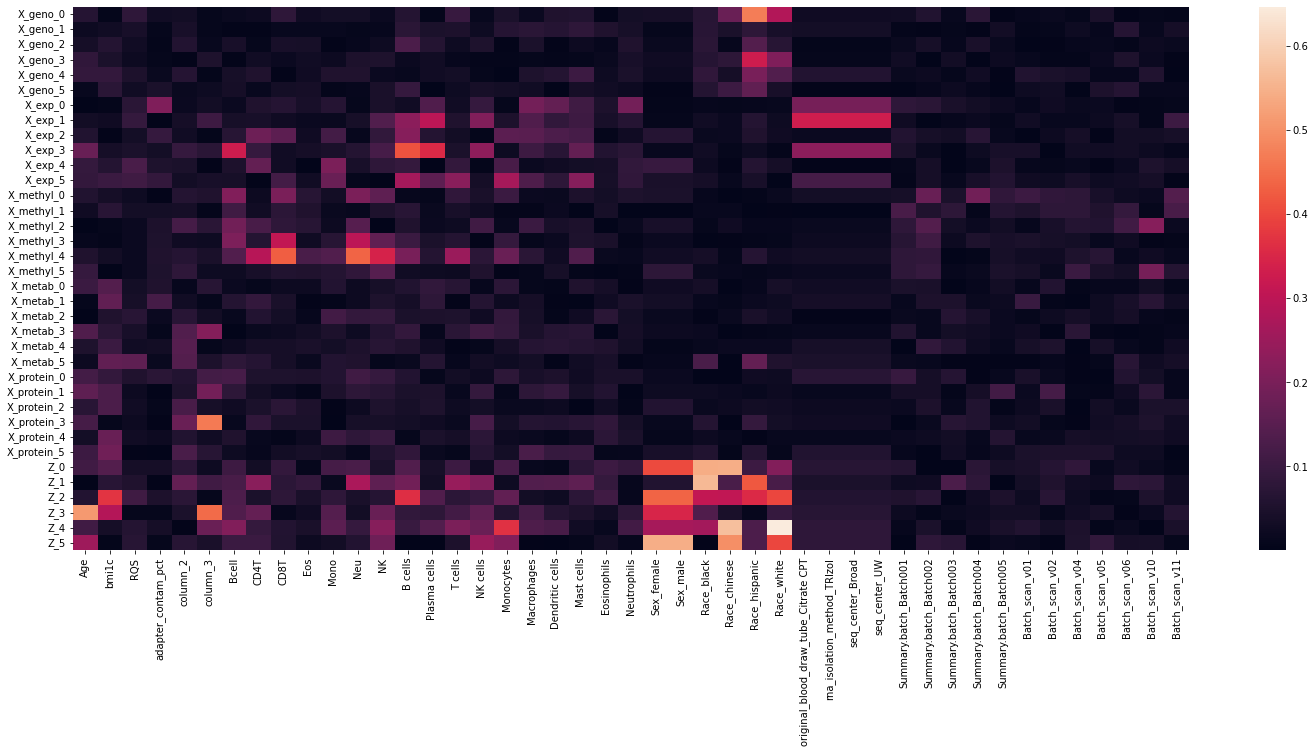

In [131]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = colnames_X + colnames_Z
cor_cols = meta_df.columns
data = abs(np.corrcoef(res_full.fillna(res_full.mean())[data_cols], res_full.fillna(res_full.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor)

In [143]:
np.corrcoef(meta_df[['seq_center_UW', 'original_blood_draw_tube_Citrate CPT', 'rna_isolation_method_TRIzol']].values, rowvar=False)

array([[ 1., -1., -1.],
       [-1.,  1.,  1.],
       [-1.,  1.,  1.]])

In [142]:
meta_df.columns

Index(['Age', 'bmi1c', 'RQS', 'adapter_contam_pct', 'column_2', 'column_3',
       'Bcell', 'CD4T', 'CD8T', 'Eos', 'Mono', 'Neu', 'NK', 'B cells',
       'Plasma cells', 'T cells', 'NK cells', 'Monocytes', 'Macrophages',
       'Dendritic cells', 'Mast cells', 'Eosinophils', 'Neutrophils',
       'Sex_female', 'Sex_male', 'Race_black', 'Race_chinese', 'Race_hispanic',
       'Race_white', 'original_blood_draw_tube_Citrate CPT',
       'rna_isolation_method_TRIzol', 'seq_center_Broad', 'seq_center_UW',
       'Summary.batch_Batch001', 'Summary.batch_Batch002',
       'Summary.batch_Batch003', 'Summary.batch_Batch004',
       'Summary.batch_Batch005', 'Batch_scan_v01', 'Batch_scan_v02',
       'Batch_scan_v04', 'Batch_scan_v05', 'Batch_scan_v06', 'Batch_scan_v10',
       'Batch_scan_v11'],
      dtype='object')

<AxesSubplot:xlabel='Z_3', ylabel='Z_5'>

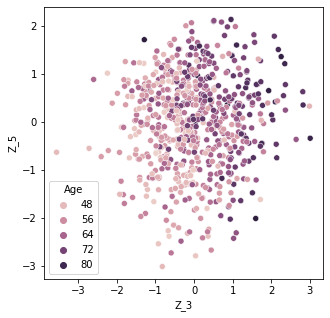

In [132]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=res_full, x='Z_3', y='Z_5', hue='Age')

<AxesSubplot:xlabel='X_exp_0', ylabel='X_exp_1'>

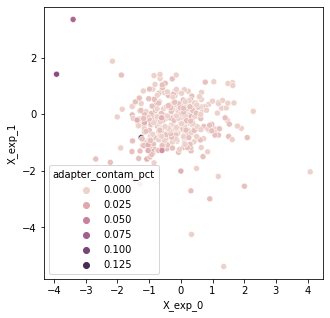

In [144]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=res_full, x='X_exp_0', y='X_exp_1', hue='adapter_contam_pct')

<AxesSubplot:xlabel='X_protein_0', ylabel='X_protein_1'>

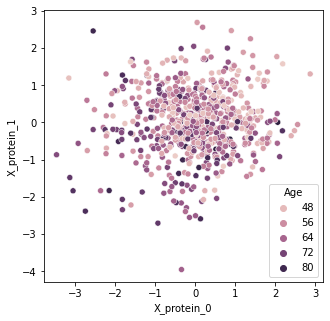

In [127]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=res_full, x='X_protein_0', y='X_protein_1', hue='Age')